In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
df_movie = pd.read_csv("/kaggle/input/movielens-20m-dataset/movie.csv")
df_rating = pd.read_csv("/kaggle/input/movielens-20m-dataset/rating.csv")
df =  pd.merge(df_rating, df_movie, on='movieId')

In [3]:
df_movie.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
df_rating.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [6]:
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,2,3.5,2005-04-02 23:53:47,Jumanji (1995),Adventure|Children|Fantasy
1,1,29,3.5,2005-04-02 23:31:16,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi
2,1,32,3.5,2005-04-02 23:33:39,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
3,1,47,3.5,2005-04-02 23:32:07,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,3.5,2005-04-02 23:29:40,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [7]:
df.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
dtype: int64

In [8]:
genre_split = []
for gen in df['genres']:
    genre_split.append(gen.split('|'))


def flatten(a):
    res = []
    for x in a:
        if isinstance(x, list):
            res.extend(flatten(x))  # Recursively flatten nested lists
        else:
            res.append(x)  # Append individual elements
    return res

gen_flat = flatten(genre_split)

In [9]:
gen_flat[:10]

['Adventure',
 'Children',
 'Fantasy',
 'Adventure',
 'Drama',
 'Fantasy',
 'Mystery',
 'Sci-Fi',
 'Mystery',
 'Sci-Fi']

In [10]:
gen_count = Counter(gen_flat)

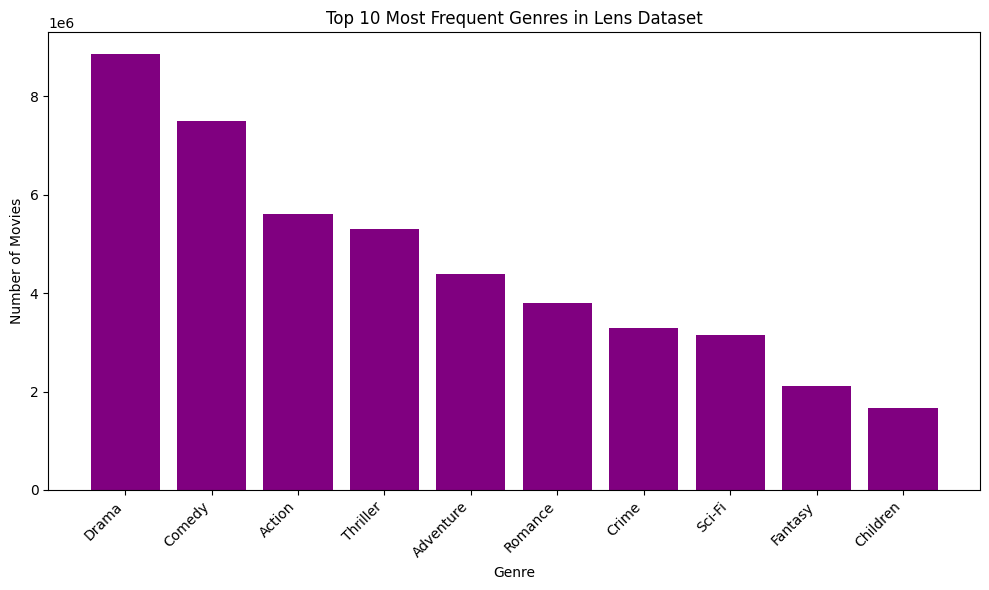

In [11]:
top_10_genres = gen_count.most_common(10)

# Convert to DataFrame for plotting
top_10_df = pd.DataFrame(top_10_genres, columns=['Genre', 'Count'])

# Plot the top 10 most frequent genres
plt.figure(figsize=(10, 6))
plt.bar(top_10_df['Genre'], top_10_df['Count'], color='purple')
plt.title("Top 10 Most Frequent Genres in Lens Dataset")
plt.xlabel("Genre")
plt.ylabel("Number of Movies")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [12]:
most_rated_movies = df.groupby('title')['rating'].sum().sort_values(ascending = False)

In [13]:
top10_rated_movies = most_rated_movies.head(10)

In [14]:
top10_rated_movies = top10_rated_movies.to_frame()
top10_rated_movies.reset_index(inplace = True)
top10_rated_movies.columns

Index(['title', 'rating'], dtype='object')

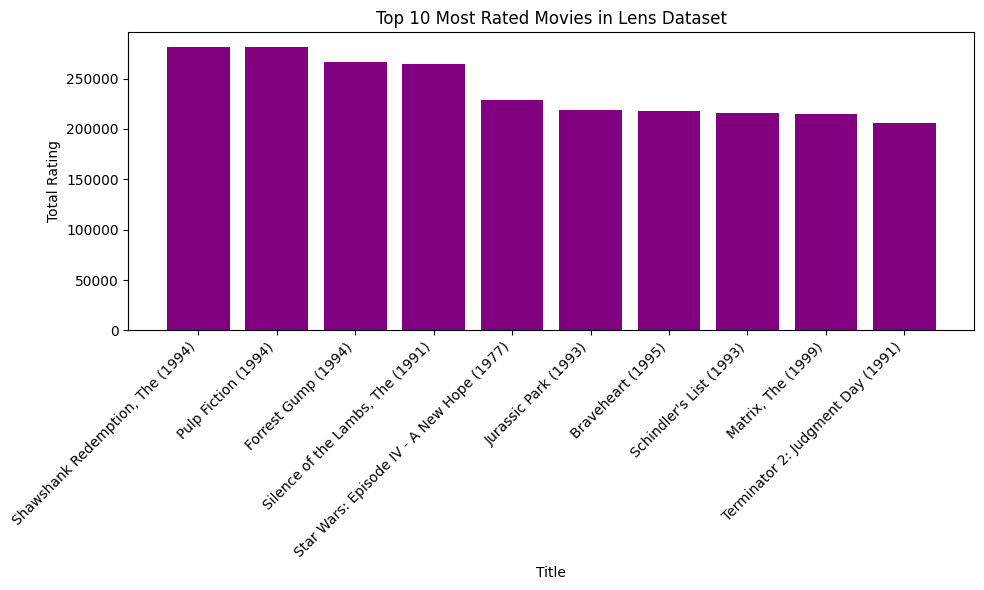

In [15]:
plt.figure(figsize=(10, 6))
plt.bar(top10_rated_movies['title'], top10_rated_movies['rating'], color='purple')
plt.title("Top 10 Most Rated Movies in Lens Dataset")
plt.xlabel("Title")
plt.ylabel("Total Rating")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [16]:
user_ratings = df.groupby('userId')['rating'].count().sort_values(ascending = False)
user_ratings = user_ratings.to_frame()
user_ratings.reset_index(inplace = True)
user_ratings

,userId,rating
0,118205,9254
1,8405,7515
2,82418,5646
3,121535,5520
4,125794,5491
...,...,...
138488,138322,20
138489,69881,20
138490,70382,20
138491,70384,20


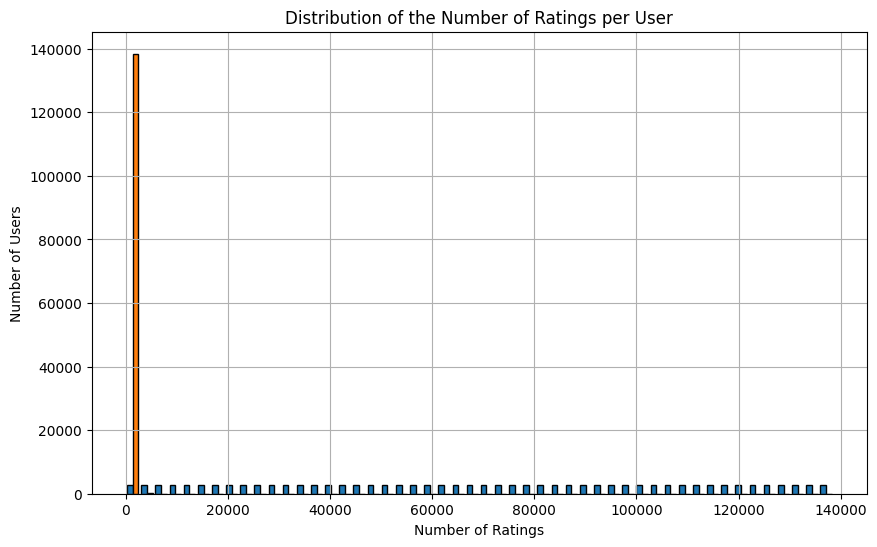

In [17]:
plt.figure(figsize=(10, 6))
plt.hist(user_ratings, bins=50, edgecolor='black')
plt.title('Distribution of the Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.grid(True)
plt.show()

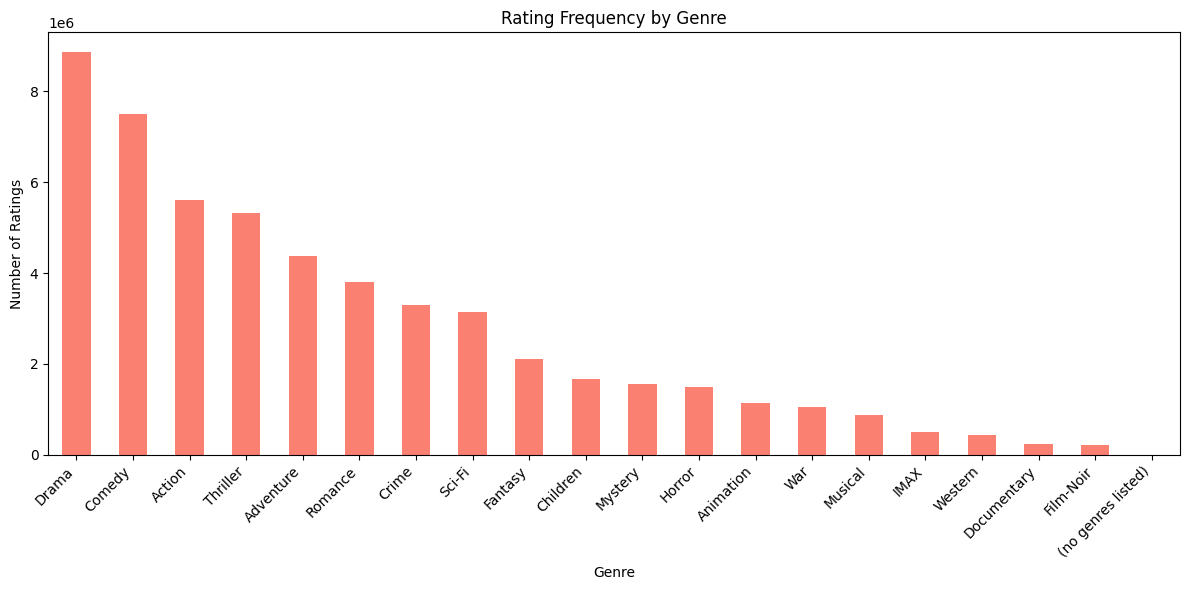

In [18]:
import seaborn as sns

# Assuming your DataFrame 'df' has columns 'genres' (separated by '|') and 'rating'

# 1. Explode the genres column to have one row per genre for each movie
genre_exploded = df.assign(genres=df['genres'].str.split('|')).explode('genres')

# 2. Group by the exploded genre and count the number of ratings for each genre
rating_frequency_per_genre = genre_exploded.groupby('genres')['rating'].count().sort_values(ascending=False)

# 3. Plot the rating frequency per genre
plt.figure(figsize=(12, 6))
rating_frequency_per_genre.plot(kind='bar', color='salmon')
plt.title('Rating Frequency by Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Requirement 1 Done**
1. *Loading data*
2. *Checking for nulls*
3. *Merging Movies with Rating datasets*
4. *visualizations :*
    * Most Frequent Genres in Movies
    * Most Rated Movies
    * User ratings
    * Rating Frequent in Genres


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
data = df.sample(10000,random_state = 42)
#Content-Based Filtering
def generate_movie_sim(df):
    df_content = df[['movieId', 'title', 'genres']].drop_duplicates()
    df_content['genres'] = df_content['genres'].str.split('|')

    df_content['genres_str'] = df_content['genres'].str.join(' ')
    tfidf = TfidfVectorizer()
    tfidf_matrix = tfidf.fit_transform(df_content['genres_str'])
    cosine_sim = cosine_similarity(tfidf_matrix)
    cosine_sim_df = pd.DataFrame(cosine_sim, index=df_content['title'], columns=df_content['title'])
    return cosine_sim_df

In [20]:
cosine_sim_movies = generate_movie_sim(data)
cosine_sim_movies.head()

title,Shrek 2 (2004),Twelve Monkeys (a.k.a. 12 Monkeys) (1995),"Grand Budapest Hotel, The (2014)",Swingers (1996),"Big Lebowski, The (1998)",No Escape (1994),U.S. Marshals (1998),Cube Zero (2004),Two Girls and a Guy (1997),"Crouching Tiger, Hidden Dragon (Wo hu cang long) (2000)",...,Mr. Nobody (2009),My Own Private Idaho (1991),Bossa Nova (2000),Three Colors: Red (Trois couleurs: Rouge) (1994),Gimme Shelter (1970),Lost in La Mancha (2002),"Odessa File, The (1974)","Hunt For Gollum, The (2009)",Revolutionary Road (2008),"Unforgiven, The (1960)"
title,,,,,,,,,,,,,,,,,,,,,
Shrek 2 (2004),1.000000,0.0,0.183984,0.183984,0.135054,0.000000,0.000000,0.000000,0.183984,0.216782,...,0.135867,0.276277,0.364069,0.00000,0.0,0.0,0.00000,0.192907,0.276277,0.00000
Twelve Monkeys (a.k.a. 12 Monkeys) (1995),0.000000,1.0,0.000000,0.000000,0.000000,0.589185,0.206696,0.880033,0.000000,0.000000,...,0.492123,0.000000,0.000000,0.00000,0.0,0.0,0.39086,0.000000,0.000000,0.00000
"Grand Budapest Hotel, The (2014)",0.183984,0.0,1.000000,1.000000,0.413367,0.213027,0.000000,0.000000,1.000000,0.283901,...,0.177933,0.361816,0.703419,0.66096,0.0,0.0,0.00000,0.000000,0.361816,0.22482
Swingers (1996),0.183984,0.0,1.000000,1.000000,0.413367,0.213027,0.000000,0.000000,1.000000,0.283901,...,0.177933,0.361816,0.703419,0.66096,0.0,0.0,0.00000,0.000000,0.361816,0.22482
"Big Lebowski, The (1998)",0.135054,0.0,0.413367,0.413367,1.000000,0.000000,0.542653,0.000000,0.413367,0.000000,...,0.000000,0.000000,0.290770,0.00000,0.0,0.0,0.00000,0.000000,0.000000,0.00000


In [21]:
def get_similar_movies(movie_title,cosine_sim_df ,top_n=10):
    similarity_scores = cosine_sim_df[movie_title]
    
    similar_movies = similarity_scores.drop(movie_title).sort_values(ascending=False).head(top_n)
    
    return similar_movies

get_similar_movies('Grand Budapest Hotel, The (2014)',cosine_sim_movies)

title
With Honors (1994)                                                                             1.0
Breaking Away (1979)                                                                           1.0
Patch Adams (1998)                                                                             1.0
Women on the Verge of a Nervous Breakdown (Mujeres al borde de un ataque de nervios) (1988)    1.0
Being Julia (2004)                                                                             1.0
Terms of Endearment (1983)                                                                     1.0
Where the Heart Is (2000)                                                                      1.0
Being There (1979)                                                                             1.0
Masked & Anonymous (2003)                                                                      1.0
Boys on the Side (1995)                                                                        1.0
Name

In [22]:
def similar_users_func(df):
    sampled_users = df['userId'].drop_duplicates()
    df_sampled = df[df['userId'].isin(sampled_users)]
    user_movie_matrix = df_sampled.pivot_table(index='userId', columns='title', values='rating')
    user_movie_matrix_filled = user_movie_matrix.fillna(0)
    user_similarity = cosine_similarity(user_movie_matrix_filled)
    user_similarity_df = pd.DataFrame(user_similarity, index=user_movie_matrix.index, columns=user_movie_matrix.index)
    return user_similarity_df,user_movie_matrix

In [23]:
user_similarity_df,user_movie_matrix = similar_users_func(data)

In [24]:
target_user_id = data['userId'].iloc[0]
user_similarity_df[target_user_id].sort_values(ascending = False).head(10)

userId
122270    1.000000
16396     1.000000
48085     1.000000
107299    1.000000
45237     1.000000
72441     1.000000
16284     1.000000
108979    1.000000
52095     1.000000
39967     0.819232
Name: 122270, dtype: float64

In [25]:
#user-based collaborative filtering
def find_similar_movies_to_user_corrected(target_usr, user_movie_matrix, similar_users, top_n_similar_users=10):
    if target_usr not in user_movie_matrix.index:
        return pd.Series(dtype=float)  # Silent fail (or raise ValueError)

    target_user_watched = user_movie_matrix.loc[target_usr].dropna().index.tolist()
    similar_user_s = similar_users[target_usr].drop(target_usr).sort_values(ascending=False)
    top_similar_users = similar_user_s.head(top_n_similar_users)

    if top_similar_users.empty:
        return pd.Series(dtype=float)  # No similar users

    recommendations = {}
    for similar_user, similarity_score in similar_user_s.items():
        if similar_user not in user_movie_matrix.index:
            continue  # Skip if user not in matrix
        similar_user_ratings = user_movie_matrix.loc[similar_user].dropna()
        unseen_movies = similar_user_ratings[~similar_user_ratings.index.isin(target_user_watched)]
        
        for movie, rating in unseen_movies.items():
            recommendations[movie] = recommendations.get(movie, 0) + similarity_score * rating

    return pd.Series(recommendations).sort_values(ascending=False).head(10)

In [26]:
print("Target user in matrix?", target_user_id in user_movie_matrix.index)
print("Similar users (top 10):", user_similarity_df[target_user_id].sort_values(ascending = False).head(10))
print("Target user's watched movies:", user_movie_matrix.loc[target_user_id].dropna().index.tolist())

Target user in matrix? True
Similar users (top 10): userId
122270    1.000000
16396     1.000000
48085     1.000000
107299    1.000000
45237     1.000000
72441     1.000000
16284     1.000000
108979    1.000000
52095     1.000000
39967     0.819232
Name: 122270, dtype: float64
Target user's watched movies: ['Shrek 2 (2004)']


In [27]:
for i in range(2):
    print(find_similar_movies_to_user_corrected( data['userId'].iloc[i],user_movie_matrix,user_similarity_df))

Broadcast News (1987)                              3.535534
Jaws (1975)                                        2.867312
Man Who Knew Too Little, The (1997)                0.000000
Gothic (1986)                                      0.000000
Wedding Planner, The (2001)                        0.000000
Distinguished Gentleman, The (1992)                0.000000
Jay and Silent Bob Strike Back (2001)              0.000000
Girl with a Pearl Earring (2003)                   0.000000
Return of the Pink Panther, The (1975)             0.000000
Three Colors: White (Trzy kolory: Bialy) (1994)    0.000000
dtype: float64
Shine (1996)                              2.300895
Larger Than Life (1996)                   0.948683
Gothic (1986)                             0.000000
Man Who Knew Too Little, The (1997)       0.000000
Delicatessen (1991)                       0.000000
Wedding Planner, The (2001)               0.000000
Distinguished Gentleman, The (1992)       0.000000
Jay and Silent Bob Strike Ba

In [28]:
def similar_movies_func(df):
    user_movie_matrix = df.pivot_table(index='userId', columns='title', values='rating')
    movie_similarity = cosine_similarity(user_movie_matrix.T.fillna(0))  # Transpose for item-item
    movie_similarity_df = pd.DataFrame(
        movie_similarity, 
        index=user_movie_matrix.columns, 
        columns=user_movie_matrix.columns
    )
    return movie_similarity_df

In [29]:
movie_similarity_df = similar_movies_func(data)

In [30]:
movie_similarity_df.head(5)

title,"'burbs, The (1989)",(500) Days of Summer (2009),*batteries not included (1987),10 Things I Hate About You (1999),"10,000 BC (2008)",101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),101 Reykjavik (101 Reykjavík) (2000),12 Angry Men (1957),12 Rounds (2009),...,Your Friends and Neighbors (1998),Zathura (2005),Zelig (1983),Zodiac (2007),Zombieland (2009),Zoolander (2001),[REC] (2007),[REC]³ 3 Génesis (2012),eXistenZ (1999),¡Three Amigos! (1986)
title,,,,,,,,,,,,,,,,,,,,,
"'burbs, The (1989)",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
(500) Days of Summer (2009),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
*batteries not included (1987),0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10 Things I Hate About You (1999),0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"10,000 BC (2008)",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Requirement 2**
1.   Using Sample of data due to processor ram limitation
2.   Using both TF-IDF and cosine similarity to get similarity matrix of movies -> *generate_movie_sim*
3.   Sorting Elements in the cosinie similarity matrix and return the top similar movies to the given movie  -> *get_similar_movies*
4.   Using movie ratings to generate a cosine similarity matrix between users ->*similar_users_func*
5.   User based colabertive filtering -> *find_similar_movies_to_user_corrected* using movie matrix and target user id generate a list of movies based on similar users for the target user 






In [31]:
class HybridRecommender:
    def __init__(self, df, content_weight=0.5, collab_weight=0.5):
        self.df = df
        self.content_weight = content_weight
        self.collab_weight = collab_weight
        
        # Generate similarity matrices
        print("Generating content-based similarity matrix...")
        self.cosine_sim_df = generate_movie_sim(df)
        
        print("Generating collaborative filtering matrices...")
        self.user_sim_df, self.user_movie_matrix = similar_users_func(df)
    
    def hybrid_recommendations(self, target_user_id, top_n=10):
        # Get collaborative filtering recommendations
        collab_recs = find_similar_movies_to_user_corrected(
            target_user_id,
            self.user_movie_matrix,
            self.user_sim_df,  # Pass the entire DF now
            top_n_similar_users=20  # Increased for better coverage
        )
        
        # Get content-based recommendations
        content_recs = self._get_content_recommendations(target_user_id, top_n*2)
        
        # Combine recommendations
        return self._combine_recommendations(collab_recs, content_recs, top_n)
    
    def _get_content_recommendations(self, user_id, top_n):
        """Get content-based recs from user's highest rated movie"""
        user_ratings = self.user_movie_matrix.loc[user_id].dropna()
        if len(user_ratings) == 0:
            return pd.Series(dtype=float)
        
        favorite_movie = user_ratings.idxmax()
        return get_similar_movies(favorite_movie, self.cosine_sim_df, top_n)
    
    def _combine_recommendations(self, collab_recs, content_recs, top_n):
        """Combine and weight recommendations from both approaches"""
        hybrid_scores = {}
        
        # Add collaborative recommendations with weight
        for movie, score in collab_recs.items():
            hybrid_scores[movie] = score * self.collab_weight
        
        # Add content recommendations with weight
        for movie, score in content_recs.items():
            if movie in hybrid_scores:
                hybrid_scores[movie] += score * self.content_weight
            else:
                hybrid_scores[movie] = score * self.content_weight
        
        # Convert to Series and return top N
        hybrid_series = pd.Series(hybrid_scores)
        return hybrid_series.sort_values(ascending=False).head(top_n)

    def evaluate(self, test_size=0.2):
        """
        Evaluate the hybrid recommender using MAE and RMSE
        
        Args:
            test_size: Proportion of data to use for testing
            
        Returns:
            Dictionary with evaluation metrics
        """
        # Split data into train and test
        train, test = train_test_split(self.df, test_size=test_size, random_state=42)
        
        # Re-train on train set
        train_recommender = HybridRecommender(train, self.content_weight, self.collab_weight)
        
        # Evaluate on test set
        predictions = []
        actuals = []
        
        for _, row in test.iterrows():
            user_id = row['userId']
            movie_title = row['title']
            actual_rating = row['rating']
            
            # Get predicted score (scale 0-5)
            try:
                recs = train_recommender.hybrid_recommendations(user_id)
                if movie_title in recs.index:
                    predicted_score = recs.loc[movie_title, 'hybrid_score']
                    # Scale prediction to 1-5 range (assuming original scores are 0.5-5)
                    max_score = recs['hybrid_score'].max()
                    predicted_rating = 0.5 + 4.5 * (predicted_score / max_score)
                else:
                    predicted_rating = self.df['rating'].mean()  # Default to mean rating
            except:
                predicted_rating = self.df['rating'].mean()
            
            predictions.append(predicted_rating)
            actuals.append(actual_rating)
        
        # Calculate metrics
        mae = mean_absolute_error(actuals, predictions)
        rmse = np.sqrt(mean_squared_error(actuals, predictions))
        
        return {
            'MAE': mae,
            'RMSE': rmse,
            'content_weight': self.content_weight,
            'collab_weight': self.collab_weight
        }

In [32]:
# Initialize with your data
recommender = HybridRecommender(data)

# Get hybrid recommendations for a user
user_id = data['userId'].iloc[0]
recommendations = recommender.hybrid_recommendations(user_id)
print(f"Hybrid recommendations for user {user_id}:")
print(recommendations)


Generating content-based similarity matrix...
Generating collaborative filtering matrices...
Hybrid recommendations for user 122270:
Broadcast News (1987)         1.767767
Jaws (1975)                   1.433656
Mulan (1998)                  0.488734
Hercules (1997)               0.471967
Aladdin (1992)                0.471967
Robin Hood (1973)             0.471967
Little Mermaid, The (1989)    0.468418
Enchanted (2007)              0.459761
Pete's Dragon (1977)          0.455769
Song of the South (1946)      0.455769
dtype: float64


In [33]:

# Evaluate the system
metrics = recommender.evaluate()
print("\nEvaluation Metrics:")
print(f"MAE: {metrics['MAE']:.3f}")
print(f"RMSE: {metrics['RMSE']:.3f}")


Generating content-based similarity matrix...
Generating collaborative filtering matrices...

Evaluation Metrics:
MAE: 0.846
RMSE: 1.060


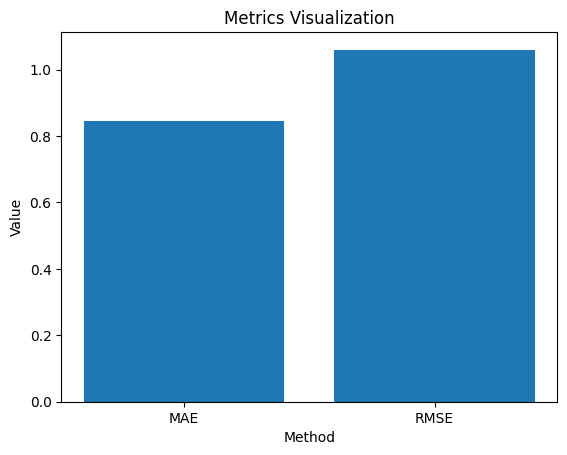

In [38]:
x = ['MAE','RMSE']
y = [metrics['MAE'],metrics['RMSE']]
plt.bar(x,y)
plt.title('Metrics Visualization')
plt.xlabel('Method')
plt.ylabel('Value')
plt.show()

**Requirement 3**

*HybridRecommender : Class takes dataframe and weightsas input and has the following functions:*
1. \__init__ -> using the dataFrame it get the cosine similarity for both movies 
and users
2. _get_content_recommendations -> private helper function to get simialar movies using user_id and implemented function in Requirement 2
returns top movies recommended for the given movie
3. _combine_recommendations -> combine both colabertive filtering and content based filtering and returns the top 10 recommended movies.
4. hybrid_recommendations -> takes the input_target and use find_similar_movies_to_user_corrected to get similar users to the given user and uses _combine_recommendations as a return.


In [36]:
metrics['MAE']

0.8461968000000001